In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

vec = TfidfVectorizer(min_df=3, stop_words='english',
                      ngram_range=(1, 2))
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lsa = make_pipeline(vec, svd)

clf = SVC(C=150, gamma=2e-2, probability=True)
pipe = make_pipeline(lsa, clf)
pipe.fit(twenty_train.data, twenty_train.target)
pipe.score(twenty_test.data, twenty_test.target)

0.8901464713715047

In [4]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    for target, prob in zip(twenty_train.target_names, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = twenty_test.data[0]
print_prediction(doc)

0.000 alt.atheism
0.000 comp.graphics
0.997 sci.med
0.003 soc.religion.christian


In [5]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)

Using TensorFlow backend.


In [6]:
import re
doc2 = re.sub(r'(recall|kidney|stones|medication|pain|tech)', '', doc, flags=re.I)
print_prediction(doc2)

0.066 alt.atheism
0.143 comp.graphics
0.355 sci.med
0.436 soc.religion.christian


In [7]:
te.show_prediction(targets=['sci.med'], target_names=twenty_train.target_names)

In [9]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

In [10]:
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# check the input format
print(model.input_shape)
dims = model.input_shape[1:3] # -> (height, width)
print(dims)

(None, 224, 224, 3)
(224, 224)


<class 'PIL.PngImagePlugin.PngImageFile'>


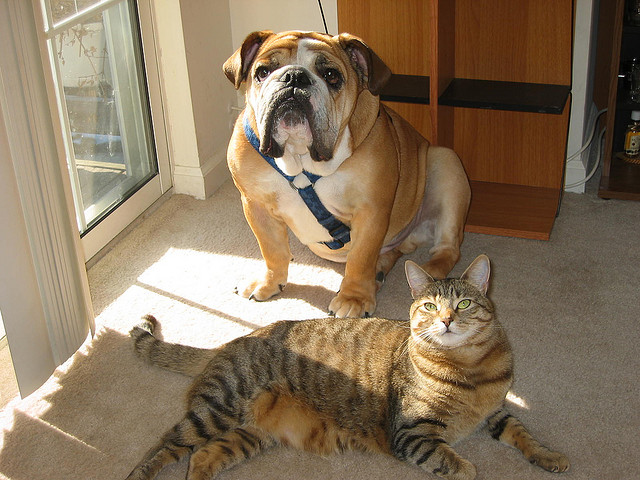

In [11]:
# we start from a path / URI.
# If you already have an image loaded, follow the subsequent steps
image = 'cat_dog.png'

# this is the original "cat dog" image used in the Grad-CAM paper
# check the image with Pillow
im = Image.open(image)
print(type(im))
display(im)

<class 'PIL.Image.Image'>


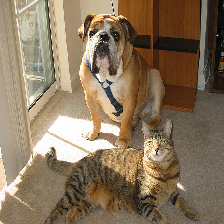

In [12]:
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
im = keras.preprocessing.image.load_img(image, target_size=dims) # -> PIL image
print(type(im))
display(im)

In [13]:
# we use a routine from `keras.preprocessing` for that as well
# we get a 'doc', an object almost ready to be inputted into the model

doc = keras.preprocessing.image.img_to_array(im) # -> numpy array
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (224, 224, 3)


In [14]:
# dimensions are looking good
# except that we are missing one thing - the batch size

# we can use a numpy routine to create an axis in the first position
doc = np.expand_dims(doc, axis=0)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


In [15]:
# one last thing
# `keras.applications` models come with their own input preprocessing function
# for best results, apply that as well

# mobilenetv2-specific preprocessing
# (this operation is in-place)
mobilenet_v2.preprocess_input(doc)
print(type(doc), doc.shape)

<class 'numpy.ndarray'> (1, 224, 224, 3)


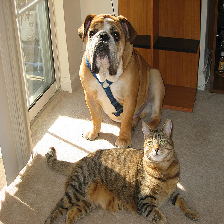

In [16]:
# take back the first image from our 'batch'
display(keras.preprocessing.image.array_to_img(doc[0]))

In [17]:
# make a prediction about our sample image
predictions = model.predict(doc)
print(type(predictions), predictions.shape)

<class 'numpy.ndarray'> (1, 1000)


In [18]:
# check the top 5 indices
# `keras.applications` contains a function for that

top = mobilenet_v2.decode_predictions(predictions)
top_indices = np.argsort(predictions)[0, ::-1][:5]

print(top)
print(top_indices)

[[('n02108422', 'bull_mastiff', 0.8096751), ('n02108089', 'boxer', 0.09835986), ('n02123045', 'tabby', 0.00665038), ('n02123159', 'tiger_cat', 0.0048087114), ('n02110958', 'pug', 0.003940979)]]
[243 242 281 282 254]


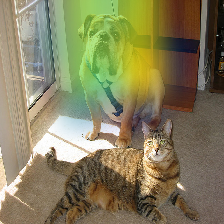

In [19]:
eli5.show_prediction(model, doc)

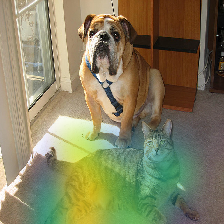

In [12]:
cat_idx = 282 # ImageNet ID for "tiger_cat" class, because we have a cat in the picture
eli5.show_prediction(model, doc, targets=[cat_idx]) # pass the class id

In [13]:
# we could use model.summary() here, but the model has over 100 layers.
# we will only look at the first few and last few layers

head = model.layers[:5]
tail = model.layers[-8:]

def pretty_print_layers(layers):
    for l in layers:
        info = [l.name, type(l).__name__, l.output_shape, l.count_params()]
        pretty_print(info)

def pretty_print(lst):
    s = ',\t'.join(map(str, lst))
    print(s)

pretty_print(['name', 'type', 'output shape', 'param. no'])
print('-'*100)
pretty_print([model.input.name, type(model.input), model.input_shape, 0])
pretty_print_layers(head)
print()
print('...')
print()
pretty_print_layers(tail)

name,	type,	output shape,	param. no
----------------------------------------------------------------------------------------------------
input_1:0,	<class 'tensorflow.python.framework.ops.Tensor'>,	(None, 224, 224, 3),	0
input_1,	InputLayer,	(None, 224, 224, 3),	0
Conv1_pad,	ZeroPadding2D,	(None, 225, 225, 3),	0
Conv1,	Conv2D,	(None, 112, 112, 32),	864
bn_Conv1,	BatchNormalization,	(None, 112, 112, 32),	128
Conv1_relu,	ReLU,	(None, 112, 112, 32),	0

...

block_16_depthwise_relu,	ReLU,	(None, 7, 7, 960),	0
block_16_project,	Conv2D,	(None, 7, 7, 320),	307200
block_16_project_BN,	BatchNormalization,	(None, 7, 7, 320),	1280
Conv_1,	Conv2D,	(None, 7, 7, 1280),	409600
Conv_1_bn,	BatchNormalization,	(None, 7, 7, 1280),	5120
out_relu,	ReLU,	(None, 7, 7, 1280),	0
global_average_pooling2d_1,	GlobalAveragePooling2D,	(None, 1280),	0
Logits,	Dense,	(None, 1000),	1281000


block_2_expand


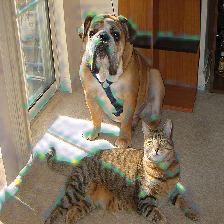

block_9_expand


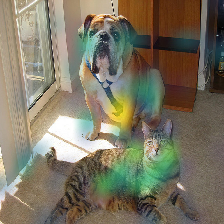

Conv_1


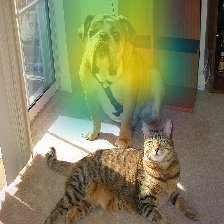

In [14]:
for l in ['block_2_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument